# Dyadic citation frequencies
In this notebook, we'll explore the frequency of citations within and across the kingdom classes of the citation network.

In [1]:
import networkx as nx
import sys
sys.path.append('../desiccation_network/conference_recommendation')
import utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import jsonlines
from math import ceil
plt.rcParams['pdf.fonttype'] = 42

## Read in data

In [2]:
graph = nx.read_graphml('../data/citation_network/FINAL_FINAL_DEBUGGED_MANUALLY_VERIFIED_core_collection_destol_or_anhydro_classified_network_29Mar2024.graphml')

In [3]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_FILTERED_MAIN_ONLY_with_ref_abstracts_05Jan2023.jsonl') as reader:
    data = [obj for obj in reader]

We need the years from the jsonlines formatted version of the dataset, but some papers were dropped for having no abstract or being truly NOCLASS or for being isolate nodes, so we want to know which those are so we can take them out later on.

In [4]:
diff_uids = [p['UID'] for p in data if p['UID'] not in graph.nodes]

In [5]:
len(diff_uids)

844

## Calculate frequencies

In [6]:
dyadic_freqs = utils.calculate_dyadic_citation_freqs(graph, 'study_system')

In [7]:
dyadic_freqs

{('Plant', 'Plant'): 0.9655477657389703,
 ('Plant', 'Animal'): 0.0145882019686991,
 ('Plant', 'Microbe'): 0.009595637702712273,
 ('Plant', 'Fungi'): 0.010268394589618299,
 ('Animal', 'Plant'): 0.07190935606910479,
 ('Animal', 'Animal'): 0.894772268341934,
 ('Animal', 'Microbe'): 0.017051828584249494,
 ('Animal', 'Fungi'): 0.01626654700471169,
 ('Microbe', 'Plant'): 0.15081470253884047,
 ('Microbe', 'Animal'): 0.054945054945054944,
 ('Microbe', 'Microbe'): 0.7601364153088291,
 ('Microbe', 'Fungi'): 0.034103827207275485,
 ('Fungi', 'Plant'): 0.362956033676333,
 ('Fungi', 'Animal'): 0.06641721234798878,
 ('Fungi', 'Microbe'): 0.04396632366697849,
 ('Fungi', 'Fungi'): 0.5266604303086997}

## Visualize
To visualize, we'll create a graph with one node to represent each study system, and then visualize the citation frequencies between nodes as edges with varying weights.

In [8]:
colors = {'Plant': '#228833', 'Animal':'#EE6677', 'Microbe': '#4477AA', 'Fungi':'#CCBB44'}

In [9]:
nodes = list(set([k[0] for k in dyadic_freqs.keys()]))
nodes = [(n, {'color': colors[n]}) for n in nodes]
nodes

[('Plant', {'color': '#228833'}),
 ('Animal', {'color': '#EE6677'}),
 ('Microbe', {'color': '#4477AA'}),
 ('Fungi', {'color': '#CCBB44'})]

In [10]:
edges = [(k[0], k[1], {'weight': round(v, 2)*10, 'color': colors[k[0]]}) for k, v in dyadic_freqs.items()]
edges[:5]

[('Plant', 'Plant', {'weight': 9.7, 'color': '#228833'}),
 ('Plant', 'Animal', {'weight': 0.1, 'color': '#228833'}),
 ('Plant', 'Microbe', {'weight': 0.1, 'color': '#228833'}),
 ('Plant', 'Fungi', {'weight': 0.1, 'color': '#228833'}),
 ('Animal', 'Plant', {'weight': 0.7000000000000001, 'color': '#EE6677'})]

In [11]:
dyadic_freq_graph = nx.MultiDiGraph()
_ = dyadic_freq_graph.add_nodes_from(nodes)
_ = dyadic_freq_graph.add_edges_from(edges)

We want to make some aesthetic changes to the self-loops, which isn't straightforward in networkx. We're going to use the code from [this StackOverflow answer](https://stackoverflow.com/questions/74350464/how-to-better-visualize-networkx-self-loop-plot) to accomplish this task.

In [12]:
class SelfLoop():
    def __init__(self, v_scale=0.25, h_scale=0.25, nodesize=100):
        self.v_scale = v_scale
        self.h_scale = h_scale
        self.nodesize = nodesize

    def selfloopstyle(self, posA, posB, *args, **kwargs):
        from matplotlib.path import Path

        selfloop_ht = 0.005 * self.nodesize

        data_loc = ax.transData.inverted().transform(posA)
        v_shift = self.v_scale * selfloop_ht
        h_shift = v_shift * self.h_scale

        path = [
            data_loc + np.asarray([0, v_shift]),
            data_loc + np.asarray([h_shift, v_shift]),
            data_loc + np.asarray([h_shift, 0]),
            data_loc,
            data_loc + np.asarray([-h_shift, 0]),
            data_loc + np.asarray([-h_shift, v_shift]),
            data_loc + np.asarray([0, v_shift]),
        ]

        ret = Path(ax.transData.transform(path), [1, 4, 4, 4, 4, 4, 4])

        return ret
    
    def style(self):
        return self.selfloopstyle

/tmp/local/34970136/ipykernel_23603/2632849464.py:14: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  e = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=edge_weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1', node_size=nodesize)


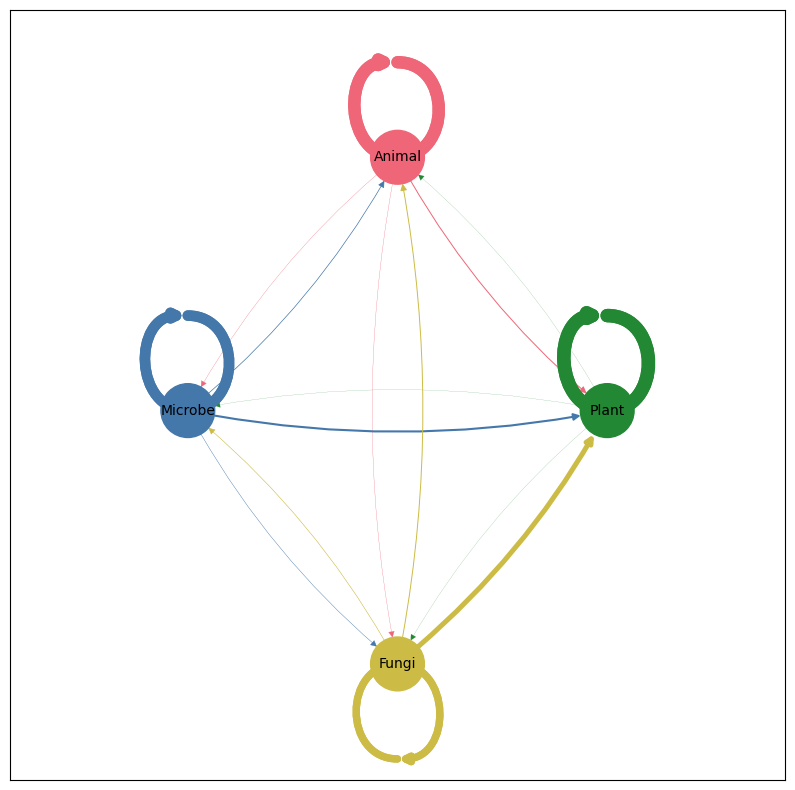

In [13]:
nodes = dyadic_freq_graph.nodes(data=True)
node_colors = [attrs['color'] for n, attrs in nodes]
edges = dyadic_freq_graph.edges(data=True)
edge_colors = [attrs['color'] for e1, e2, attrs in edges]
edge_weights = [attrs['weight'] for e1, e2, attrs in edges]

pos = nx.circular_layout(dyadic_freq_graph)
fig, ax = plt.subplots(figsize=(10,10))
plt.margins(x=0.2)

nodesize=1500
nx.draw_networkx_nodes(dyadic_freq_graph, pos, node_size=nodesize, node_color=node_colors)
_ = nx.draw_networkx_labels(dyadic_freq_graph, pos, font_size=10, font_family="sans-serif")
e = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=edge_weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1', node_size=nodesize)

ax.set_xlim([1.2*x for x in ax.get_xlim()])
ax.set_ylim([1.2*y for y in ax.get_ylim()])

horiz = 0.7
vert = 0.05
for i, edge in enumerate(edges):
    if edge[0] == edge[1]:
        if edge[0] == 'Fungi':
            e[i]._connector = SelfLoop(-vert, horiz, nodesize=nodesize).style() #select self loop and change connector
            ax.add_patch(e[i]) #add the patch to ax
#         elif edge[0] == 'Plant':
#             e[i]._connector = SelfLoop(vert, horiz, nodesize=nodesize).style() #select self loop and change connector
#             ax.add_patch(e[i]) #add the patch to ax
#         elif edge[0] == 'Microbe':
#             e[i]._connector = SelfLoop(vert, horiz, nodesize=nodesize).style() #select self loop and change connector
#             ax.add_patch(e[i]) #add the patch to ax
#         elif edge[0] == 'Fungi':
        else:
            e[i]._connector = SelfLoop(vert, horiz, nodesize=nodesize).style() #select self loop and change connector
            ax.add_patch(e[i]) #add the patch to ax
plt.savefig('../data/citation_network/figures/fig_4B.pdf', format='pdf', bbox_inches='tight', dpi=600)

## Siloing over time
One way to potentially establish an expectation for whether or not our siloing is closer or farther from a hypothetical baseline is to look at siloing over time. If we see that siloing is getting worse, then we for sure want to suggest that reasearchers take approaches to try and cite outside their own discipline. However, if we find it's getting better, then we can place more faith in our current practices.

To do this, we'll start at the earliest year, and then keep adding on decades and computing the dyadic citation frequencies for all papers up to the end of the decade. We can make a visualization by plotting the ratio of self:other citations for each discipline on the y versus a time x axis.

In [14]:
years = {}
for paper in data:
    try:
        years[paper['UID']] = int(paper['year'])
    except KeyError:
        continue
first_dec = round(min(years.values()), -1)
last_dec = round(max(years.values()), -1)
if last_dec <= max(years.values()):
    last_dec += 10
print(f'The earliest year in our dataset is {min(years.values())}, so our first cutoff will be {first_dec}.')
print(f'The last year in our dataset is {max(years.values())}, so our last decade cutoff will be {last_dec}.')
all_decs = [first_dec + 10*i for i in range(int((last_dec/10) - (first_dec/10)) + 1)]
print(f'All decade cutoff list: {all_decs}')
year_splits = defaultdict(list)
for uid, year in years.items():
    decade = int(np.floor(year / 10) * 10)
    year_splits[decade].append(uid)

The earliest year in our dataset is 1956, so our first cutoff will be 1960.
The last year in our dataset is 2023, so our last decade cutoff will be 2030.
All decade cutoff list: [1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]


In [15]:
dec_graphs = {}
for dec_cut in all_decs:
    all_uids = [uid for year, uids in year_splits.items() for uid in uids if (year < dec_cut) and (uid not in diff_uids)]
    print(f'There are {len(all_uids)} papers in the classified network that were published before {dec_cut}')
    if len(all_uids) > 0:
        subgraph = graph.subgraph(all_uids)
        dec_graphs[dec_cut] = subgraph

There are 0 papers in the classified network that were published before 1960
There are 0 papers in the classified network that were published before 1970
There are 0 papers in the classified network that were published before 1980
There are 0 papers in the classified network that were published before 1990
There are 697 papers in the classified network that were published before 2000
There are 2053 papers in the classified network that were published before 2010
There are 4287 papers in the classified network that were published before 2020
There are 5119 papers in the classified network that were published before 2030


In [16]:
dec_freqs = {dec_cut: utils.calculate_dyadic_citation_freqs(graph, 'study_system') for dec_cut, graph in dec_graphs.items()}

In [17]:
sys_trajectories = {}
for system in ['Plant', 'Animal', 'Microbe', 'Fungi']:
    sys_traj = []
    for year in sorted(dec_freqs.keys()):
        sys_traj.append(dec_freqs[year][(system, system)])
    sys_trajectories[system] = sys_traj

In [18]:
node_attrs = nx.get_node_attributes(graph, 'study_system')
ppy = {}
for system in ['Plant', 'Animal', 'Microbe', 'Fungi']:
    ps = []
    for dec_cut in sorted(dec_freqs.keys()):
        all_papers = [uid for year, uids in year_splits.items() for uid in uids if (year < dec_cut) and (uid not in diff_uids)]
        all_paper_classes = {k: node_attrs[k] for k in all_papers}
        this_class_papers = [uid for uid, sys in all_paper_classes.items() if sys == system]
        ps.append(len(this_class_papers))
    ppy[system] = ps

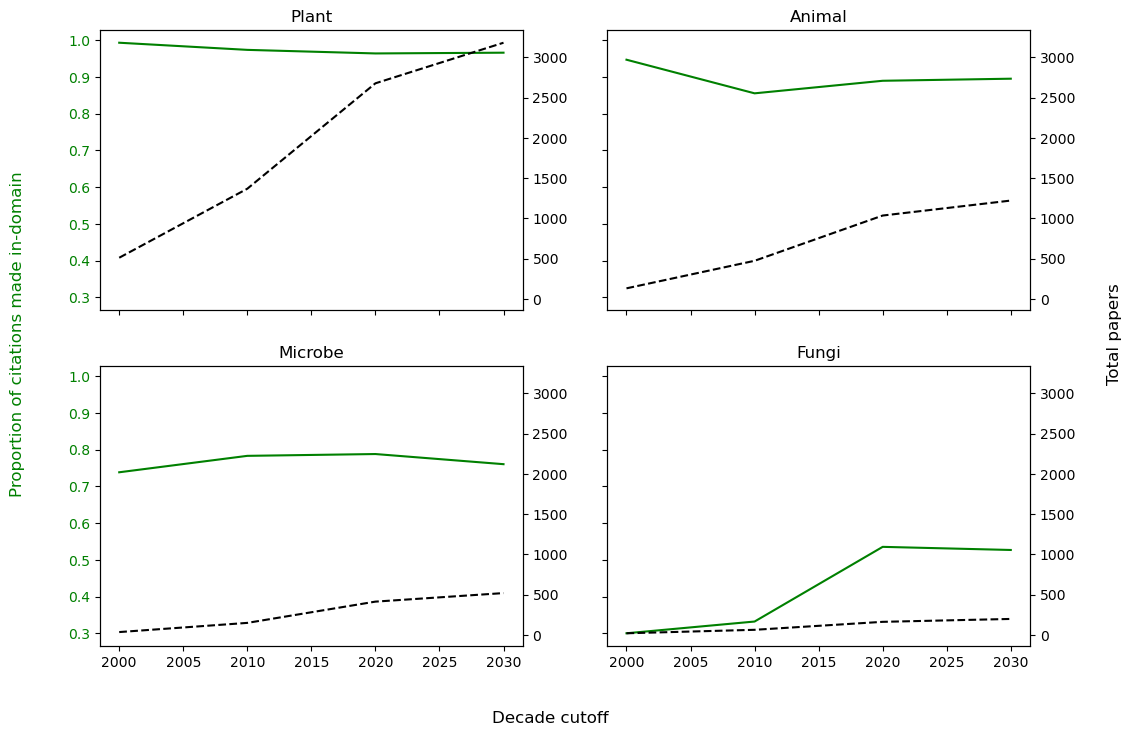

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey='all', sharex=True)

raxs = []
for i, sys in enumerate(['Plant', 'Animal', 'Microbe', 'Fungi']):
    ax.tick_params(axis='y', labelcolor='green')
    ax = axs.reshape(-1)[i]
    rax = ax.twinx()
    raxs.append(rax)
    if i > 0:
        rax.sharey(raxs[i-1])   
    ax.plot(sorted(dec_freqs.keys()), sys_trajectories[sys], label=sys, color='green')
    rax.plot(sorted(dec_freqs.keys()), ppy[sys], linestyle='--', color='black')
    ax.set_title(sys)
fig.supylabel('Proportion of citations made in-domain', fontsize=12, x=0.05, color='green')
fig.text(x=0.97, y=0.5, s='Total papers', rotation=90, size=12, ha='center', va='center')
fig.supxlabel('Decade cutoff')
plt.savefig('../data/citation_network/figures/fig_5.pdf', format='pdf', bbox_inches='tight', dpi=600)

## Test explantory hypotheses
In this section, we'll take a look at some of the hypotheses from [Theory Meets Empiry: A Citation Network Analysis](https://academic.oup.com/bioscience/article-pdf/68/10/805/26119302/biy083.pdf).

### Lack-of-integration hypothesis
States that researchers primarily cite within their own discipline; this agrees with what we see for all disciplines except (almost) Fungi, where the discipline cites Plants nearly as often as they cite themselves.

### Null expectation hypothesis
One explanation for why Plant papers cite their own discipline so much more often is because they make up such a large proportion of the literature in this field. Specifically, one statement of this null hypothesis is that each paper should cite each discipline in the frequency that it appears in the larger literature. For example, if Plant papers are 70% of the literature, 70% of all citations for any paper should be to Plant papers. We can see that this isn't true just looking at the first figure we made; Animal and Microbe disciplines cite themselves much more than others, and certainly don't cite Plant papers at 70%.

### Size-of-community hypothesis
States that the smaller a discipline is, the more likely it is to cite itself. This is not what we see here, since Fungi have the least insulated citation pattern, as opposed to the most, which is what this hypothesis would predict.

## Distribution of degrees
Another thing we may want to look at is the distribution of in-degree/out-degree in each discipline, so we can plot that here.

In [21]:
# Separate nodeIDs by class
class_node_UIDs = defaultdict(list)
for node, attrs in graph.nodes(data=True):
    class_node_UIDs[attrs['study_system']].append(node)

In [22]:
# Get in and out degrees
in_degrees = {'study_system': [], 'in_degree': []}
for study_system in ['Plant', 'Animal', 'Microbe', 'Fungi']:
    for deg in graph.in_degree(class_node_UIDs[study_system]):
        in_degrees['study_system'].append(study_system)
        in_degrees['in_degree'].append(deg[1])
in_deg_df = pd.DataFrame(in_degrees)
out_degrees = {'study_system': [], 'out_degree': []}
for study_system in ['Plant', 'Animal', 'Microbe', 'Fungi']:
    for deg in graph.out_degree(class_node_UIDs[study_system]):
        out_degrees['study_system'].append(study_system)
        out_degrees['out_degree'].append(deg[1])
out_deg_df = pd.DataFrame(out_degrees)

/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


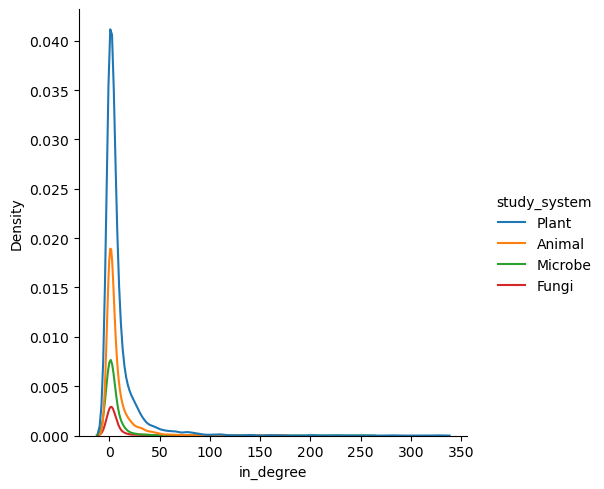

In [23]:
# Plot
sns.displot(data=in_degrees, x='in_degree', hue='study_system', kind='kde')

/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


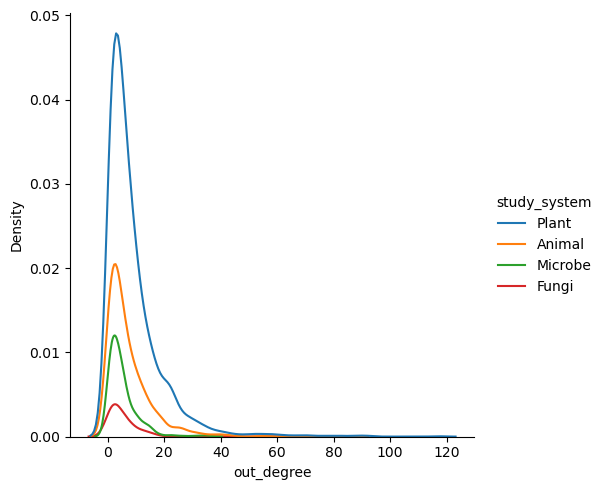

In [24]:
# Plot
sns.displot(data=out_degrees, x='out_degree', hue='study_system', kind='kde')